# RNN & Word Embeddings for SEC Filings to Predict Returns

RNNs are commonly applied to various natural language processing tasks. We've already encountered sentiment analysis using text data in part three of this book.

We are now going to apply an RNN model to SEC filings to learn custom word embeddings (see Chapter 16) and predict the returns over the week after the filing date.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from time import time
from collections import Counter
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import yfinance as yf

from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, GRU, Bidirectional,
                                     Embedding, BatchNormalization, Dropout)
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
idx = pd.IndexSlice
sns.set_style('whitegrid')

In [6]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

In [7]:
deciles = np.arange(.1, 1, .1).round(1)

## Get stock price data

### Paths

In [8]:
data_path = Path('..', 'data', 'sec-filings')

In [9]:
results_path = Path('results', 'sec-filings')

selected_section_path = results_path / 'ngrams_1'
ngram_path = results_path / 'ngrams'
vector_path = results_path / 'vectors'

for path in [vector_path, selected_section_path, ngram_path]:
    if not path.exists():
        path.mkdir(parents=True)

### Get filing info

In [10]:
filing_index = (pd.read_csv(data_path / 'filing_index.csv',
                            parse_dates=['DATE_FILED'])
                .rename(columns=str.lower))
filing_index.index += 1

In [11]:
filing_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22631 entries, 1 to 22631
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   cik           22631 non-null  int64         
 1   company_name  22631 non-null  object        
 2   form_type     22631 non-null  object        
 3   date_filed    22631 non-null  datetime64[ns]
 4   edgar_link    22631 non-null  object        
 5   quarter       22631 non-null  int64         
 6   ticker        22631 non-null  object        
 7   sic           22461 non-null  object        
 8   exchange      20619 non-null  object        
 9   hits          22555 non-null  object        
 10  year          22631 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 1.9+ MB


In [12]:
filing_index.head()

,cik,company_name,form_type,date_filed,edgar_link,quarter,ticker,sic,exchange,hits,year
1,1000180,SANDISK CORP,10-K,2013-02-19,edgar/data/1000180/0001000180-13-000009.txt,1,SNDK,3572,NASDAQ,3,2013
2,1000209,MEDALLION FINANCIAL CORP,10-K,2013-03-13,edgar/data/1000209/0001193125-13-103504.txt,1,TAXI,6199,NASDAQ,0,2013
3,1000228,HENRY SCHEIN INC,10-K,2013-02-13,edgar/data/1000228/0001000228-13-000010.txt,1,HSIC,5047,NASDAQ,3,2013
4,1000229,CORE LABORATORIES N V,10-K,2013-02-19,edgar/data/1000229/0001000229-13-000009.txt,1,CLB,1389,NYSE,2,2013
5,1000232,KENTUCKY BANCSHARES INC KY,10-K,2013-03-28,edgar/data/1000232/0001104659-13-025094.txt,1,KTYB,6022,OTC,0,2013


In [13]:
filing_index.ticker.nunique()

6630

In [14]:
filing_index.date_filed.describe()

count                   22631
unique                    980
top       2014-03-31 00:00:00
freq                      442
first     2013-01-02 00:00:00
last      2016-12-30 00:00:00
Name: date_filed, dtype: object

### Download stock price data using Yfinance

In [23]:
yf_data, missing = [], []
for i, (symbol, dates) in enumerate(filing_index.groupby('ticker').date_filed, 1):
    
    if i % 250 == 0:
        print(i, len(yf_data), len(set(missing)), flush=True)
    
    ticker = yf.Ticker(symbol)
    for filing, date in dates.to_dict().items():
        start = date - timedelta(days=93)
        end = date + timedelta(days=31)
        df = ticker.history(start=start, end=end)
        if df.empty:
            missing.append(symbol)
        else:
            yf_data.append(df.assign(ticker=symbol, filing=filing))

- AAC: No data found, symbol may be delisted
- AAC: No data found, symbol may be delisted
- AAC: No data found, symbol may be delisted
- AAPH: No data found, symbol may be delisted
- AAPH: No data found, symbol may be delisted
- AARI: No data found for this date range, symbol may be delisted
- AARI: No data found for this date range, symbol may be delisted
- AARI: No data found for this date range, symbol may be delisted
- AARI: No data found for this date range, symbol may be delisted
- AARS: No data found, symbol may be delisted
- AARS: No data found, symbol may be delisted
- AAVL: Data doesn't exist for startDate = 1417496400, endDate = 1428206400
- AAVL: Data doesn't exist for startDate = 1449032400, endDate = 1459742400
- ABCR: No data found for this date range, symbol may be delisted
- ABCW: No data found for this date range, symbol may be delisted
- ABCW: No data found for this date range, symbol may be delisted
- ABCW: No data found for this date range, symbol may be delisted
-

- ADHXF: No data found for this date range, symbol may be delisted
- ADHXF: No data found for this date range, symbol may be delisted
- ADHXF: No data found for this date range, symbol may be delisted
- ADK: Data doesn't exist for startDate = 1365220800, endDate = 1375934400
- ADK: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ADK: Data doesn't exist for startDate = 1419742800, endDate = 1430452800
- ADK: Data doesn't exist for startDate = 1451278800, endDate = 1461988800
- ADMA: Data doesn't exist for startDate = 1354510800, endDate = 1365220800
- ADMC: No data found, symbol may be delisted
- ADMC: No data found, symbol may be delisted
- ADMC: No data found, symbol may be delisted
- ADMD: No data found for this date range, symbol may be delisted
- ADMD: No data found for this date range, symbol may be delisted
- ADMD: No data found for this date range, symbol may be delisted
- ADMD: No data found for this date range, symbol may be delisted
- ADNC: No data found

- AKAO: No data found, symbol may be delisted
- AKAO: No data found, symbol may be delisted
- AKRN: No data found for this date range, symbol may be delisted
- ALC: Data doesn't exist for startDate = 1355202000, endDate = 1365912000
- ALDR: No data found, symbol may be delisted
- ALDR: No data found, symbol may be delisted
- ALDW: No data found for this date range, symbol may be delisted
- ALDW: No data found for this date range, symbol may be delisted
- ALDW: No data found for this date range, symbol may be delisted
- ALDW: No data found for this date range, symbol may be delisted
- ALFE: Data doesn't exist for startDate = 1356498000, endDate = 1367208000
- ALFE: Data doesn't exist for startDate = 1388379600, endDate = 1399089600
- ALGI: No data found, symbol may be delisted
- ALGI: No data found, symbol may be delisted
- ALIM: Data doesn't exist for startDate = 1356411600, endDate = 1367121600
- ALIM: Data doesn't exist for startDate = 1386133200, endDate = 1396843200
- ALIM: Data do

- ANAD: No data found for this date range, symbol may be delisted
- ANAD: No data found for this date range, symbol may be delisted
- ANAD: No data found for this date range, symbol may be delisted
- ANAD: No data found for this date range, symbol may be delisted
- ANCI: No data found for this date range, symbol may be delisted
- ANCI: No data found for this date range, symbol may be delisted
- ANCI: No data found for this date range, symbol may be delisted
- ANCI: No data found for this date range, symbol may be delisted
- ANCV: No data found, symbol may be delisted
- ANCV: No data found, symbol may be delisted
- ANCV: No data found, symbol may be delisted
- ANCV: No data found, symbol may be delisted
- ANGN: No data found for this date range, symbol may be delisted
- ANGN: No data found for this date range, symbol may be delisted
- ANGN: No data found for this date range, symbol may be delisted
- ANGN: No data found for this date range, symbol may be delisted
- ANLT: Data doesn't exi

- ARGS: No data found for this date range, symbol may be delisted
- ARGS: No data found for this date range, symbol may be delisted
- ARIA: No data found for this date range, symbol may be delisted
- ARIA: No data found for this date range, symbol may be delisted
- ARIA: No data found for this date range, symbol may be delisted
- ARIA: No data found for this date range, symbol may be delisted
- ARIS: No data found for this date range, symbol may be delisted
- ARIS: No data found for this date range, symbol may be delisted
- ARIS: No data found for this date range, symbol may be delisted
- ARIS: No data found for this date range, symbol may be delisted
- ARLZ: No data found for this date range, symbol may be delisted
- ARMX: No data found, symbol may be delisted
- ARO: No data found for this date range, symbol may be delisted
- ARO: No data found for this date range, symbol may be delisted
- ARO: No data found for this date range, symbol may be delisted
- ARO: No data found for this dat

- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1385787600, endDate = 1396497600
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- ATLS: Data

- BBCZ: Data doesn't exist for startDate = 1358053200, endDate = 1368763200
- BBDS: No data found, symbol may be delisted
- BBEP: No data found for this date range, symbol may be delisted
- BBEP: No data found for this date range, symbol may be delisted
- BBEP: No data found for this date range, symbol may be delisted
- BBEP: No data found for this date range, symbol may be delisted
- BBG: No data found for this date range, symbol may be delisted
- BBG: No data found for this date range, symbol may be delisted
- BBG: No data found for this date range, symbol may be delisted
- BBG: No data found for this date range, symbol may be delisted
- BBGR: No data found for this date range, symbol may be delisted
- BBGR: No data found for this date range, symbol may be delisted
- BBLF: No data found, symbol may be delisted
- BBLF: No data found, symbol may be delisted
- BBLF: No data found, symbol may be delisted
- BBLF: No data found, symbol may be delisted
- BBLU: No data found for this date ra

- BIOS: No data found, symbol may be delisted
- BIOS: No data found, symbol may be delisted
- BIOS: No data found, symbol may be delisted
- BIOS: No data found, symbol may be delisted
- BISN: No data found, symbol may be delisted
- BISN: No data found, symbol may be delisted
- BISN: No data found, symbol may be delisted
- BISN: No data found, symbol may be delisted
- BITI: No data found for this date range, symbol may be delisted
- BKFS: No data found for this date range, symbol may be delisted
750 1675 297
- BKGM: No data found for this date range, symbol may be delisted
- BKGM: No data found for this date range, symbol may be delisted
- BKGM: No data found for this date range, symbol may be delisted
- BKGM: No data found for this date range, symbol may be delisted
- BKI: Data doesn't exist for startDate = 1369713600, endDate = 1380427200
- BKJ: No data found, symbol may be delisted
- BKJ: No data found, symbol may be delisted
- BKJ: No data found, symbol may be delisted
- BKJ: No dat

- BOLC: No data found for this date range, symbol may be delisted
- BOLC: No data found for this date range, symbol may be delisted
- BOLC: No data found for this date range, symbol may be delisted
- BOLC: No data found for this date range, symbol may be delisted
- BOLD: Data doesn't exist for startDate = 1382241600, endDate = 1392958800
- BONE: No data found for this date range, symbol may be delisted
- BONE: No data found for this date range, symbol may be delisted
- BONE: No data found for this date range, symbol may be delisted
- BONE: No data found for this date range, symbol may be delisted
- BONT: No data found for this date range, symbol may be delisted
- BONT: No data found for this date range, symbol may be delisted
- BONT: No data found for this date range, symbol may be delisted
- BONT: No data found for this date range, symbol may be delisted
- BONU: No data found, symbol may be delisted
- BONU: No data found, symbol may be delisted
- BOPH: No data found, symbol may be del

- BWLD: No data found for this date range, symbol may be delisted
- BWLD: No data found for this date range, symbol may be delisted
- BWLD: No data found for this date range, symbol may be delisted
- BWLD: No data found for this date range, symbol may be delisted
- BWS: No data found for this date range, symbol may be delisted
- BWS: No data found for this date range, symbol may be delisted
- BWS: No data found for this date range, symbol may be delisted
- BWS: No data found for this date range, symbol may be delisted
- BXG: Data doesn't exist for startDate = 1356757200, endDate = 1367467200
- BXLT: No data found for this date range, symbol may be delisted
- BYCX: No data found for this date range, symbol may be delisted
- BYI: No data found for this date range, symbol may be delisted
- BYI: No data found for this date range, symbol may be delisted
- BYLK: No data found for this date range, symbol may be delisted
- BYLK: No data found for this date range, symbol may be delisted
- BYLK:

- CBR: No data found for this date range, symbol may be delisted
- CBR: No data found for this date range, symbol may be delisted
- CBR: No data found for this date range, symbol may be delisted
- CBR: No data found for this date range, symbol may be delisted
- CBRX: No data found for this date range, symbol may be delisted
- CBRX: No data found for this date range, symbol may be delisted
- CBRX: No data found for this date range, symbol may be delisted
- CBRX: No data found for this date range, symbol may be delisted
- CBSJ: No data found, symbol may be delisted
- CBSJ: No data found, symbol may be delisted
- CBSJ: No data found, symbol may be delisted
- CBSJ: No data found, symbol may be delisted
- CBSO: No data found for this date range, symbol may be delisted
- CBSO: No data found for this date range, symbol may be delisted
- CBST: No data found for this date range, symbol may be delisted
- CBST: No data found for this date range, symbol may be delisted
- CBTEQ: No data found, symb

- CEU: No data found, symbol may be delisted
- CEU: No data found, symbol may be delisted
- CEU: No data found, symbol may be delisted
- CEXI: No data found for this date range, symbol may be delisted
- CEXI: No data found for this date range, symbol may be delisted
- CEXI: No data found for this date range, symbol may be delisted
- CEYY: No data found for this date range, symbol may be delisted
- CEYY: No data found for this date range, symbol may be delisted
- CEYY: No data found for this date range, symbol may be delisted
- CEYY: No data found for this date range, symbol may be delisted
- CFD: No data found for this date range, symbol may be delisted
- CFD: No data found for this date range, symbol may be delisted
- CFD: No data found for this date range, symbol may be delisted
- CFD: No data found for this date range, symbol may be delisted
- CFEC: No data found for this date range, symbol may be delisted
- CFED: No data found for this date range, symbol may be delisted
- CFED: No 

- CLAI: No data found for this date range, symbol may be delisted
- CLBH: No data found for this date range, symbol may be delisted
- CLBH: No data found for this date range, symbol may be delisted
- CLBH: No data found for this date range, symbol may be delisted
- CLBH: No data found for this date range, symbol may be delisted
- CLD: No data found, symbol may be delisted
- CLD: No data found, symbol may be delisted
- CLD: No data found, symbol may be delisted
- CLD: No data found, symbol may be delisted
- CLDN: No data found for this date range, symbol may be delisted
- CLDN: No data found for this date range, symbol may be delisted
- CLDN: No data found for this date range, symbol may be delisted
- CLGL: No data found for this date range, symbol may be delisted
- CLGL: No data found for this date range, symbol may be delisted
- CLGL: No data found for this date range, symbol may be delisted
- CLGY: No data found for this date range, symbol may be delisted
- CLGY: No data found for th

- CNXC: No data found for this date range, symbol may be delisted
- COB: No data found for this date range, symbol may be delisted
- COB: No data found for this date range, symbol may be delisted
- COB: No data found for this date range, symbol may be delisted
- COB: No data found for this date range, symbol may be delisted
- COBK: No data found for this date range, symbol may be delisted
- COBK: No data found for this date range, symbol may be delisted
- COBK: No data found for this date range, symbol may be delisted
- COBR: No data found for this date range, symbol may be delisted
- COBR: No data found for this date range, symbol may be delisted
- COBT: No data found for this date range, symbol may be delisted
- COBT: No data found for this date range, symbol may be delisted
- COBT: No data found for this date range, symbol may be delisted
- COBT: No data found for this date range, symbol may be delisted
- COCO: No data found for this date range, symbol may be delisted
- CODE: Data d

- CSDI: No data found, symbol may be delisted
- CSDI: No data found, symbol may be delisted
- CSDI: No data found, symbol may be delisted
- CSDI: No data found, symbol may be delisted
- CSG: No data found for this date range, symbol may be delisted
- CSG: No data found for this date range, symbol may be delisted
- CSG: No data found for this date range, symbol may be delisted
- CSG: No data found for this date range, symbol may be delisted
- CSGN: No data found for this date range, symbol may be delisted
- CSH: No data found for this date range, symbol may be delisted
- CSH: No data found for this date range, symbol may be delisted
- CSH: No data found for this date range, symbol may be delisted
- CSH: No data found for this date range, symbol may be delisted
- CST: No data found for this date range, symbol may be delisted
- CST: No data found for this date range, symbol may be delisted
- CST: No data found for this date range, symbol may be delisted
- CTCM: No data found for this date

- CYNO: No data found for this date range, symbol may be delisted
- CYNO: No data found for this date range, symbol may be delisted
- CYNO: No data found for this date range, symbol may be delisted
- CYNX: No data found for this date range, symbol may be delisted
- CYT: No data found for this date range, symbol may be delisted
- CYT: No data found for this date range, symbol may be delisted
- CYT: No data found for this date range, symbol may be delisted
- CYTA: No data found, symbol may be delisted
- CYTX: No data found, symbol may be delisted
- CYTX: No data found, symbol may be delisted
- CYTX: No data found, symbol may be delisted
- CYTX: No data found, symbol may be delisted
- CZFC: No data found, symbol may be delisted
- CZFC: No data found, symbol may be delisted
- CZFC: No data found, symbol may be delisted
- CZFC: No data found, symbol may be delisted
- DAFX: No data found, symbol may be delisted
- DAGM: No data found for this date range, symbol may be delisted
- DAGM: No data

- DIL: No data found for this date range, symbol may be delisted
- DIL: No data found for this date range, symbol may be delisted
- DIMU: No data found, symbol may be delisted
- DIMU: No data found, symbol may be delisted
- DIMU: No data found, symbol may be delisted
- DIRI: No data found for this date range, symbol may be delisted
- DIRI: No data found for this date range, symbol may be delisted
- DIRI: No data found for this date range, symbol may be delisted
- DIRI: No data found for this date range, symbol may be delisted
- DIVALL: No data found, symbol may be delisted
- DIVALL: No data found, symbol may be delisted
- DIVALL: No data found, symbol may be delisted
- DIVALL: No data found, symbol may be delisted
- DJRT: No data found for this date range, symbol may be delisted
- DJRT: No data found for this date range, symbol may be delisted
- DJRT: No data found for this date range, symbol may be delisted
- DKII: No data found for this date range, symbol may be delisted
- DKII: No d

- DTLA: No data found, symbol may be delisted
- DTLA: No data found, symbol may be delisted
- DTLA: No data found, symbol may be delisted
- DTLK: No data found for this date range, symbol may be delisted
- DTLK: No data found for this date range, symbol may be delisted
- DTLK: No data found for this date range, symbol may be delisted
- DTLK: No data found for this date range, symbol may be delisted
- DTOR: No data found for this date range, symbol may be delisted
- DTOR: No data found for this date range, symbol may be delisted
- DTSI: No data found for this date range, symbol may be delisted
- DTSI: No data found for this date range, symbol may be delisted
- DTSI: No data found for this date range, symbol may be delisted
- DTSI: No data found for this date range, symbol may be delisted
- DTV: No data found, symbol may be delisted
- DTV: No data found, symbol may be delisted
- DTV: No data found, symbol may be delisted
- DUCK: No data found for this date range, symbol may be delisted
-

- EFLO: No data found for this date range, symbol may be delisted
- EFLO: No data found for this date range, symbol may be delisted
- EFRC: No data found, symbol may be delisted
- EFTB: No data found, symbol may be delisted
- EFTB: No data found, symbol may be delisted
- EFTB: No data found, symbol may be delisted
- EFTB: No data found, symbol may be delisted
- EGCT: No data found for this date range, symbol may be delisted
- EGCT: No data found for this date range, symbol may be delisted
- EGCT: No data found for this date range, symbol may be delisted
- EGCT: No data found for this date range, symbol may be delisted
- EGL: Data doesn't exist for startDate = 1355806800, endDate = 1366516800
- EGL: Data doesn't exist for startDate = 1386651600, endDate = 1397361600
- EGL: Data doesn't exist for startDate = 1417410000, endDate = 1428120000
- EGLT: No data found for this date range, symbol may be delisted
- EGLT: No data found for this date range, symbol may be delisted
- EGLT: No data f

- EPOC: No data found, symbol may be delisted
- EQU: No data found for this date range, symbol may be delisted
- EQU: No data found for this date range, symbol may be delisted
- EQY: No data found for this date range, symbol may be delisted
- EQY: No data found for this date range, symbol may be delisted
- EQY: No data found for this date range, symbol may be delisted
- EQY: No data found for this date range, symbol may be delisted
- ERB: No data found for this date range, symbol may be delisted
- ERB: No data found for this date range, symbol may be delisted
- ERB: No data found for this date range, symbol may be delisted
- ERI: Data doesn't exist for startDate = 1356498000, endDate = 1367208000
- ERI: Data doesn't exist for startDate = 1389502800, endDate = 1400212800
- EROC: No data found for this date range, symbol may be delisted
- EROC: No data found for this date range, symbol may be delisted
- EROC: No data found for this date range, symbol may be delisted
- ERS: No data found 

- EXLP: No data found for this date range, symbol may be delisted
- EXLP: No data found for this date range, symbol may be delisted
- EXLP: No data found for this date range, symbol may be delisted
- EXLP: No data found for this date range, symbol may be delisted
- EXXI: No data found for this date range, symbol may be delisted
- EXXI: No data found for this date range, symbol may be delisted
- EXXI: No data found for this date range, symbol may be delisted
- EXXI: No data found for this date range, symbol may be delisted
- EYNO: No data found, symbol may be delisted
- EYNO: No data found, symbol may be delisted
- EYNO: No data found, symbol may be delisted
- EYNO: No data found, symbol may be delisted
- FAC: No data found for this date range, symbol may be delisted
- FAC: No data found for this date range, symbol may be delisted
- FAC: No data found for this date range, symbol may be delisted
- FAC: No data found for this date range, symbol may be delisted
- FACT: No data found for th

- FHCO: No data found for this date range, symbol may be delisted
- FHCO: No data found for this date range, symbol may be delisted
- FHWY: No data found for this date range, symbol may be delisted
- FHWY: No data found for this date range, symbol may be delisted
- FHWY: No data found for this date range, symbol may be delisted
- FHWY: No data found for this date range, symbol may be delisted
2250 4875 921
- FIDM: No data found, symbol may be delisted
- FIDM: No data found, symbol may be delisted
- FIDM: No data found, symbol may be delisted
- FIDM: No data found, symbol may be delisted
- FIG: No data found for this date range, symbol may be delisted
- FIG: No data found for this date range, symbol may be delisted
- FIG: No data found for this date range, symbol may be delisted
- FIG: No data found for this date range, symbol may be delisted
- FIO: No data found for this date range, symbol may be delisted
- FISH: No data found for this date range, symbol may be delisted
- FISH: No data

- FRYP: No data found for this date range, symbol may be delisted
- FRYP: No data found for this date range, symbol may be delisted
- FSAC: Data doesn't exist for startDate = 1358053200, endDate = 1368763200
- FSAC: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- FSAC: Data doesn't exist for startDate = 1418706000, endDate = 1429416000
- FSAC: Data doesn't exist for startDate = 1451192400, endDate = 1461902400
- FSBK: No data found for this date range, symbol may be delisted
- FSBK: No data found for this date range, symbol may be delisted
- FSBK: No data found for this date range, symbol may be delisted
- FSBK: No data found for this date range, symbol may be delisted
- FSC: No data found for this date range, symbol may be delisted
- FSC: No data found for this date range, symbol may be delisted
- FSC: No data found for this date range, symbol may be delisted
- FSC: No data found for this date range, symbol may be delisted
- FSDB: No data found, symbol may be del

- GCMN: No data found for this date range, symbol may be delisted
- GCMN: No data found for this date range, symbol may be delisted
- GCMN: No data found for this date range, symbol may be delisted
- GCMN: No data found for this date range, symbol may be delisted
- GDEF: No data found for this date range, symbol may be delisted
- GDEF: No data found for this date range, symbol may be delisted
- GDEF: No data found for this date range, symbol may be delisted
- GDI: Data doesn't exist for startDate = 1353906000, endDate = 1364616000
- GDP: Data doesn't exist for startDate = 1353474000, endDate = 1364184000
- GDP: Data doesn't exist for startDate = 1384923600, endDate = 1395633600
- GDP: Data doesn't exist for startDate = 1417237200, endDate = 1427947200
- GDP: Data doesn't exist for startDate = 1451278800, endDate = 1461988800
- GDSW: No data found, symbol may be delisted
- GDSW: No data found, symbol may be delisted
- GDSW: No data found, symbol may be delisted
- GDSW: No data found, sy

- GNMT: No data found for this date range, symbol may be delisted
- GNMT: No data found for this date range, symbol may be delisted
- GNRGE: No data found, symbol may be delisted
- GNVC: No data found for this date range, symbol may be delisted
- GNVC: No data found for this date range, symbol may be delisted
- GNVC: No data found for this date range, symbol may be delisted
- GNVC: No data found for this date range, symbol may be delisted
- GOAS: No data found for this date range, symbol may be delisted
- GOAS: No data found for this date range, symbol may be delisted
- GOAS: No data found for this date range, symbol may be delisted
- GOAS: No data found for this date range, symbol may be delisted
- GOBK: No data found, symbol may be delisted
- GOBK: No data found, symbol may be delisted
- GOBK: No data found, symbol may be delisted
- GOBK: No data found, symbol may be delisted
- GOCM: No data found for this date range, symbol may be delisted
- GOKN: No data found for this date range, 

- GY: No data found for this date range, symbol may be delisted
- GY: No data found for this date range, symbol may be delisted
- GY: No data found for this date range, symbol may be delisted
- GY: No data found for this date range, symbol may be delisted
- GYCK: No data found, symbol may be delisted
- GYMB: No data found for this date range, symbol may be delisted
- GYMB: No data found for this date range, symbol may be delisted
- GYMB: No data found for this date range, symbol may be delisted
- GYMB: No data found for this date range, symbol may be delisted
- GZFX: No data found for this date range, symbol may be delisted
- GZGT: No data found for this date range, symbol may be delisted
- GZGT: No data found for this date range, symbol may be delisted
- GZGT: No data found for this date range, symbol may be delisted
- HAMP: No data found for this date range, symbol may be delisted
- HAMP: No data found for this date range, symbol may be delisted
- HAMP: No data found for this date ra

- HH: No data found for this date range, symbol may be delisted
- HHBR: No data found for this date range, symbol may be delisted
- HHWW: No data found, symbol may be delisted
- HHWW: No data found, symbol may be delisted
- HHWW: No data found, symbol may be delisted
- HICKA: No data found, symbol may be delisted
- HICKA: No data found, symbol may be delisted
- HICKA: No data found, symbol may be delisted
- HICKA: No data found, symbol may be delisted
- HICKA: No data found, symbol may be delisted
- HIFR: No data found, symbol may be delisted
- HIFR: No data found, symbol may be delisted
- HIIQ: No data found, symbol may be delisted
- HIIQ: No data found, symbol may be delisted
- HIIQ: No data found, symbol may be delisted
- HIIQ: No data found, symbol may be delisted
- HILL: No data found for this date range, symbol may be delisted
- HILL: No data found for this date range, symbol may be delisted
- HILL: No data found for this date range, symbol may be delisted
- HITT: No data found f

- HTCO: No data found for this date range, symbol may be delisted
- HTHH: No data found, symbol may be delisted
- HTS: No data found for this date range, symbol may be delisted
- HTS: No data found for this date range, symbol may be delisted
- HTS: No data found for this date range, symbol may be delisted
- HTS: No data found for this date range, symbol may be delisted
- HTWO: No data found, symbol may be delisted
- HTWO: No data found, symbol may be delisted
- HTWO: No data found, symbol may be delisted
- HTZ: Data doesn't exist for startDate = 1354338000, endDate = 1365048000
- HTZ: Data doesn't exist for startDate = 1387170000, endDate = 1397880000
- HTZ: Data doesn't exist for startDate = 1428984000, endDate = 1439697600
- HTZ: Data doesn't exist for startDate = 1448686800, endDate = 1459396800
- HUBA: No data found for this date range, symbol may be delisted
- HUBA: No data found for this date range, symbol may be delisted
- HUBA: No data found for this date range, symbol may be d

- IFMI: No data found for this date range, symbol may be delisted
- IFMI: No data found for this date range, symbol may be delisted
- IFO: No data found for this date range, symbol may be delisted
- IFO: No data found for this date range, symbol may be delisted
- IFO: No data found for this date range, symbol may be delisted
- IFO: No data found for this date range, symbol may be delisted
- IFRS: No data found for this date range, symbol may be delisted
- IFRS: No data found for this date range, symbol may be delisted
3000 6461 1239
- IFT: No data found for this date range, symbol may be delisted
- IFT: No data found for this date range, symbol may be delisted
- IFT: No data found for this date range, symbol may be delisted
- IFT: No data found for this date range, symbol may be delisted
- IFT: No data found for this date range, symbol may be delisted
- IFT: No data found for this date range, symbol may be delisted
- IFT: No data found for this date range, symbol may be delisted
- IFT:

- INSW: Data doesn't exist for startDate = 1385355600, endDate = 1396065600
- INSW: Data doesn't exist for startDate = 1419742800, endDate = 1430452800
- INSW: Data doesn't exist for startDate = 1452661200, endDate = 1463371200
- INSY: No data found for this date range, symbol may be delisted
- INSY: No data found for this date range, symbol may be delisted
- INSY: No data found for this date range, symbol may be delisted
- INVN: No data found for this date range, symbol may be delisted
- INVN: No data found for this date range, symbol may be delisted
- INVN: No data found for this date range, symbol may be delisted
- INVN: No data found for this date range, symbol may be delisted
- IOSA: No data found for this date range, symbol may be delisted
- IOSA: No data found for this date range, symbol may be delisted
- IOSA: No data found for this date range, symbol may be delisted
- IOSA: No data found for this date range, symbol may be delisted
- IOT: No data found for this date range, symb

- JAXB: No data found for this date range, symbol may be delisted
- JAXB: No data found for this date range, symbol may be delisted
- JAXB: No data found for this date range, symbol may be delisted
- JAZ: Data doesn't exist for startDate = 1356498000, endDate = 1367208000
- JAZ: Data doesn't exist for startDate = 1385787600, endDate = 1396497600
- JAZ: Data doesn't exist for startDate = 1420606800, endDate = 1431316800
- JBII: No data found, symbol may be delisted
- JBII: No data found, symbol may be delisted
- JBII: No data found, symbol may be delisted
- JBII: No data found, symbol may be delisted
- JCG: No data found for this date range, symbol may be delisted
- JCG: No data found for this date range, symbol may be delisted
- JCG: No data found for this date range, symbol may be delisted
- JCG: No data found for this date range, symbol may be delisted
- JCOF: No data found, symbol may be delisted
- JCOF: No data found, symbol may be delisted
- JCOF: No data found, symbol may be deli

- KGKO: No data found for this date range, symbol may be delisted
- KGKO: No data found for this date range, symbol may be delisted
- KGKO: No data found for this date range, symbol may be delisted
- KID: No data found for this date range, symbol may be delisted
- KID: No data found for this date range, symbol may be delisted
- KIOR: No data found for this date range, symbol may be delisted
- KIOR: No data found for this date range, symbol may be delisted
- KIPS: No data found for this date range, symbol may be delisted
- KIPS: No data found for this date range, symbol may be delisted
- KIPS: No data found for this date range, symbol may be delisted
- KITE: No data found for this date range, symbol may be delisted
- KITE: No data found for this date range, symbol may be delisted
- KITM: No data found for this date range, symbol may be delisted
- KITM: No data found for this date range, symbol may be delisted
- KJFI: Data doesn't exist for startDate = 1367121600, endDate = 1377835200
- 

- LGCY: No data found, symbol may be delisted
- LGCY: No data found, symbol may be delisted
- LGCY: No data found, symbol may be delisted
- LGCY: No data found, symbol may be delisted
- LGDI: No data found for this date range, symbol may be delisted
- LGDI: No data found for this date range, symbol may be delisted
- LGF: No data found for this date range, symbol may be delisted
- LGF: No data found for this date range, symbol may be delisted
- LGF: No data found for this date range, symbol may be delisted
- LGF: No data found for this date range, symbol may be delisted
- LGMB: No data found for this date range, symbol may be delisted
- LGMB: No data found for this date range, symbol may be delisted
- LGP: No data found for this date range, symbol may be delisted
- LGP: No data found for this date range, symbol may be delisted
- LGP: No data found for this date range, symbol may be delisted
- LGP: No data found for this date range, symbol may be delisted
- LHSI: No data found, symbol ma

- LRE: No data found for this date range, symbol may be delisted
- LRE: No data found for this date range, symbol may be delisted
- LRE: No data found for this date range, symbol may be delisted
- LRMK: No data found for this date range, symbol may be delisted
- LRMK: No data found for this date range, symbol may be delisted
- LRMK: No data found for this date range, symbol may be delisted
- LRMK: No data found for this date range, symbol may be delisted
- LRNC: No data found, symbol may be delisted
- LRNC: No data found, symbol may be delisted
- LRNC: No data found, symbol may be delisted
- LRNC: No data found, symbol may be delisted
- LRY: No data found for this date range, symbol may be delisted
- LRY: No data found for this date range, symbol may be delisted
- LRY: No data found for this date range, symbol may be delisted
- LRY: No data found for this date range, symbol may be delisted
- LSBI: No data found for this date range, symbol may be delisted
- LSBI: No data found for this 

- MCRS: No data found for this date range, symbol may be delisted
- MCRS: No data found for this date range, symbol may be delisted
- MCZ: No data found for this date range, symbol may be delisted
- MCZ: No data found for this date range, symbol may be delisted
- MCZ: No data found for this date range, symbol may be delisted
- MCZ: No data found for this date range, symbol may be delisted
- MDAS: No data found for this date range, symbol may be delisted
- MDAS: No data found for this date range, symbol may be delisted
- MDAS: No data found for this date range, symbol may be delisted
- MDBL: No data found, symbol may be delisted
- MDBL: No data found, symbol may be delisted
- MDBL: No data found, symbol may be delisted
- MDBL: No data found, symbol may be delisted
- MDCI: No data found for this date range, symbol may be delisted
- MDCI: No data found for this date range, symbol may be delisted
- MDCO: No data found, symbol may be delisted
- MDCO: No data found, symbol may be delisted
- 

- MHP: No data found for this date range, symbol may be delisted
- MHR: No data found for this date range, symbol may be delisted
- MHR: No data found for this date range, symbol may be delisted
- MHR: No data found for this date range, symbol may be delisted
- MHR: No data found for this date range, symbol may be delisted
- MHUT: No data found for this date range, symbol may be delisted
- MHUT: No data found for this date range, symbol may be delisted
- MHUT: No data found for this date range, symbol may be delisted
- MHUT: No data found for this date range, symbol may be delisted
- MIG: Data doesn't exist for startDate = 1354683600, endDate = 1365393600
- MIG: Data doesn't exist for startDate = 1385960400, endDate = 1396670400
- MIG: Data doesn't exist for startDate = 1417237200, endDate = 1427947200
3750 8091 1544
- MIK: Data doesn't exist for startDate = 1355288400, endDate = 1365998400
- MIK: Data doesn't exist for startDate = 1390712400, endDate = 1401422400
- MILB: No data found

- MREE: No data found for this date range, symbol may be delisted
- MRFD: No data found for this date range, symbol may be delisted
- MRGE: Data doesn't exist for startDate = 1354942800, endDate = 1365652800
- MRGE: Data doesn't exist for startDate = 1386738000, endDate = 1397448000
- MRGE: Data doesn't exist for startDate = 1416978000, endDate = 1427688000
- MRH: Data doesn't exist for startDate = 1353733200, endDate = 1364443200
- MRH: Data doesn't exist for startDate = 1385355600, endDate = 1396065600
- MRH: Data doesn't exist for startDate = 1416805200, endDate = 1427515200
- MRIC: No data found, symbol may be delisted
- MRIC: No data found, symbol may be delisted
- MRIC: No data found, symbol may be delisted
- MRIC: No data found, symbol may be delisted
- MRVC: No data found for this date range, symbol may be delisted
- MRVC: No data found for this date range, symbol may be delisted
- MRVC: No data found for this date range, symbol may be delisted
- MRVC: No data found for this da

- NANA: No data found for this date range, symbol may be delisted
- NANA: No data found for this date range, symbol may be delisted
- NANA: No data found for this date range, symbol may be delisted
- NANM: No data found, symbol may be delisted
- NANM: No data found, symbol may be delisted
- NANO: No data found, symbol may be delisted
- NANO: No data found, symbol may be delisted
- NANO: No data found, symbol may be delisted
- NANO: No data found, symbol may be delisted
- NAQ: No data found for this date range, symbol may be delisted
- NASV: No data found, symbol may be delisted
- NASV: No data found, symbol may be delisted
- NASV: No data found, symbol may be delisted
- NATL: No data found for this date range, symbol may be delisted
- NATL: No data found for this date range, symbol may be delisted
- NATL: No data found for this date range, symbol may be delisted
- NATL: No data found for this date range, symbol may be delisted
- NAVG: No data found, symbol may be delisted
- NAVG: No da

- NHTB: No data found for this date range, symbol may be delisted
- NHTB: No data found for this date range, symbol may be delisted
- NHTB: No data found for this date range, symbol may be delisted
- NHTB: No data found for this date range, symbol may be delisted
- NHYT: No data found for this date range, symbol may be delisted
- NHYT: No data found for this date range, symbol may be delisted
- NHYT: No data found for this date range, symbol may be delisted
- NHYT: No data found for this date range, symbol may be delisted
- NIHD: Data doesn't exist for startDate = 1353992400, endDate = 1364702400
- NIHD: Data doesn't exist for startDate = 1385528400, endDate = 1396238400
- NIHD: Data doesn't exist for startDate = 1417928400, endDate = 1428638400
- NILE: No data found for this date range, symbol may be delisted
- NILE: No data found for this date range, symbol may be delisted
- NILE: No data found for this date range, symbol may be delisted
- NILE: No data found for this date range, sym

- NTI: No data found for this date range, symbol may be delisted
- NTI: No data found for this date range, symbol may be delisted
- NTI: No data found for this date range, symbol may be delisted
- NTI: No data found for this date range, symbol may be delisted
- NTI: No data found for this date range, symbol may be delisted
- NTI: No data found for this date range, symbol may be delisted
- NTI: No data found for this date range, symbol may be delisted
- NTI: No data found for this date range, symbol may be delisted
- NTK: No data found for this date range, symbol may be delisted
- NTK: No data found for this date range, symbol may be delisted
- NTK: No data found for this date range, symbol may be delisted
- NTK: No data found for this date range, symbol may be delisted
- NTLS: No data found for this date range, symbol may be delisted
- NTLS: No data found for this date range, symbol may be delisted
- NTLS: No data found for this date range, symbol may be delisted
- NTLS: No data found 

- OCIR: No data found, symbol may be delisted
- OCIR: No data found, symbol may be delisted
- OCIR: No data found, symbol may be delisted
- OCLS: No data found for this date range, symbol may be delisted
- OCLS: No data found for this date range, symbol may be delisted
- OCLS: No data found for this date range, symbol may be delisted
- OCLS: No data found for this date range, symbol may be delisted
- OCR: No data found for this date range, symbol may be delisted
- OCR: No data found for this date range, symbol may be delisted
- OCR: No data found for this date range, symbol may be delisted
- OCRX: No data found for this date range, symbol may be delisted
- OCRX: No data found for this date range, symbol may be delisted
- OCRX: No data found for this date range, symbol may be delisted
- OCRX: No data found for this date range, symbol may be delisted
- OCTL: No data found, symbol may be delisted
- OCTL: No data found, symbol may be delisted
- OCTL: No data found, symbol may be delisted
-

- ORFG: No data found, symbol may be delisted
- ORFG: No data found, symbol may be delisted
- ORFG: No data found, symbol may be delisted
- ORFG: No data found, symbol may be delisted
- ORFG: No data found, symbol may be delisted
- ORG: Data doesn't exist for startDate = 1362200400, endDate = 1372910400
- ORIT: No data found, symbol may be delisted
- ORIT: No data found, symbol may be delisted
- ORIT: No data found, symbol may be delisted
- ORIT: No data found, symbol may be delisted
- ORM: No data found, symbol may be delisted
- ORM: No data found, symbol may be delisted
- ORM: No data found, symbol may be delisted
- ORNG: No data found for this date range, symbol may be delisted
- ORNG: No data found for this date range, symbol may be delisted
- ORNG: No data found for this date range, symbol may be delisted
- ORPN: No data found for this date range, symbol may be delisted
- ORPN: No data found for this date range, symbol may be delisted
- ORPN: No data found for this date range, sym

- PAWS: No data found, symbol may be delisted
- PAWS: No data found, symbol may be delisted
- PAWS: No data found, symbol may be delisted
- PAYD: Data doesn't exist for startDate = 1357966800, endDate = 1368676800
- PAYD: Data doesn't exist for startDate = 1388206800, endDate = 1398916800
- PAYD: Data doesn't exist for startDate = 1419656400, endDate = 1430366400
- PAYD: Data doesn't exist for startDate = 1451278800, endDate = 1461988800
- PBCP: No data found for this date range, symbol may be delisted
- PBCP: No data found for this date range, symbol may be delisted
- PBCP: No data found for this date range, symbol may be delisted
- PBCP: No data found for this date range, symbol may be delisted
- PBCW: No data found, symbol may be delisted
- PBCW: No data found, symbol may be delisted
- PBCW: No data found, symbol may be delisted
- PBCW: No data found, symbol may be delisted
- PBIB: No data found for this date range, symbol may be delisted
- PBIB: No data found for this date range, s

- PGN: No data found for this date range, symbol may be delisted
- PGN: No data found for this date range, symbol may be delisted
- PGN: No data found for this date range, symbol may be delisted
- PGN: No data found for this date range, symbol may be delisted
- PGRX: No data found, symbol may be delisted
- PGSI: No data found, symbol may be delisted
- PGSI: No data found, symbol may be delisted
- PGSI: No data found, symbol may be delisted
- PHCO: No data found for this date range, symbol may be delisted
- PHCO: No data found for this date range, symbol may be delisted
- PHCO: No data found for this date range, symbol may be delisted
- PHCO: No data found for this date range, symbol may be delisted
- PHII: No data found for this date range, symbol may be delisted
- PHII: No data found for this date range, symbol may be delisted
- PHII: No data found for this date range, symbol may be delisted
- PHII: No data found for this date range, symbol may be delisted
- PHMD: No data found for th

- PNHV: No data found, symbol may be delisted
- PNK: Data doesn't exist for startDate = 1354078800, endDate = 1364788800
- PNK: Data doesn't exist for startDate = 1385787600, endDate = 1396497600
- PNK: Data doesn't exist for startDate = 1417237200, endDate = 1427947200
- PNK: Data doesn't exist for startDate = 1448686800, endDate = 1459396800
- PNRA: No data found for this date range, symbol may be delisted
- PNRA: No data found for this date range, symbol may be delisted
- PNRA: No data found for this date range, symbol may be delisted
- PNRA: No data found for this date range, symbol may be delisted
- PNX: Data doesn't exist for startDate = 1388293200, endDate = 1399003200
- PNX: Data doesn't exist for startDate = 1399262400, endDate = 1409976000
- PNX: Data doesn't exist for startDate = 1419742800, endDate = 1430452800
- PNX: Data doesn't exist for startDate = 1449982800, endDate = 1460692800
- PNY: No data found for this date range, symbol may be delisted
- PNY: No data found for 

- PSTB: No data found for this date range, symbol may be delisted
- PSTB: No data found for this date range, symbol may be delisted
- PSTB: No data found for this date range, symbol may be delisted
- PSTB: No data found for this date range, symbol may be delisted
- PSTR: No data found for this date range, symbol may be delisted
- PSTR: No data found for this date range, symbol may be delisted
- PSTR: No data found for this date range, symbol may be delisted
- PSTX: No data found for this date range, symbol may be delisted
- PSUN: No data found for this date range, symbol may be delisted
- PSUN: No data found for this date range, symbol may be delisted
- PSUN: No data found for this date range, symbol may be delisted
- PTEK: No data found for this date range, symbol may be delisted
- PTEK: No data found for this date range, symbol may be delisted
- PTEK: No data found for this date range, symbol may be delisted
- PTEK: No data found for this date range, symbol may be delisted
- PTEK: No

- QPRJ: No data found for this date range, symbol may be delisted
- QPRJ: No data found for this date range, symbol may be delisted
- QPRJ: No data found for this date range, symbol may be delisted
- QPRJ: No data found for this date range, symbol may be delisted
- QRE: No data found for this date range, symbol may be delisted
- QRE: No data found for this date range, symbol may be delisted
- QSII: No data found for this date range, symbol may be delisted
- QSII: No data found for this date range, symbol may be delisted
- QSII: No data found for this date range, symbol may be delisted
- QSII: No data found for this date range, symbol may be delisted
- QTET: No data found for this date range, symbol may be delisted
- QTM: No data found for this date range, symbol may be delisted
- QTM: No data found for this date range, symbol may be delisted
- QTM: No data found for this date range, symbol may be delisted
- QTM: No data found for this date range, symbol may be delisted
- QTUM: Data doe

- RHRS: No data found for this date range, symbol may be delisted
- RHRS: No data found for this date range, symbol may be delisted
- RHRS: No data found for this date range, symbol may be delisted
- RHRS: No data found for this date range, symbol may be delisted
- RHT: No data found, symbol may be delisted
- RHT: No data found, symbol may be delisted
- RHT: No data found, symbol may be delisted
- RHT: No data found, symbol may be delisted
- RIBS: Data doesn't exist for startDate = 1354683600, endDate = 1365393600
- RIBS: Data doesn't exist for startDate = 1387170000, endDate = 1397880000
- RIBS: Data doesn't exist for startDate = 1417582800, endDate = 1428292800
- RICE: No data found for this date range, symbol may be delisted
- RICE: No data found for this date range, symbol may be delisted
- RICE: No data found for this date range, symbol may be delisted
- RIGP: No data found for this date range, symbol may be delisted
- RIGP: No data found for this date range, symbol may be deliste

- RRMS: No data found for this date range, symbol may be delisted
- RRMS: No data found for this date range, symbol may be delisted
- RRMS: No data found for this date range, symbol may be delisted
- RRMS: No data found for this date range, symbol may be delisted
- RRPH: No data found for this date range, symbol may be delisted
- RRPH: No data found for this date range, symbol may be delisted
- RSCR: No data found for this date range, symbol may be delisted
- RSCR: No data found for this date range, symbol may be delisted
- RSE: No data found for this date range, symbol may be delisted
- RSE: No data found for this date range, symbol may be delisted
- RSE: No data found for this date range, symbol may be delisted
- RSE: No data found for this date range, symbol may be delisted
- RSO: No data found for this date range, symbol may be delisted
- RSO: No data found for this date range, symbol may be delisted
- RSO: No data found for this date range, symbol may be delisted
- RSO: No data fo

- SBCP: No data found for this date range, symbol may be delisted
- SBCP: No data found for this date range, symbol may be delisted
- SBII: No data found for this date range, symbol may be delisted
- SBII: No data found for this date range, symbol may be delisted
- SBSA: No data found for this date range, symbol may be delisted
- SBSA: No data found for this date range, symbol may be delisted
- SBSA: No data found for this date range, symbol may be delisted
- SBSA: No data found for this date range, symbol may be delisted
- SBTB: No data found, symbol may be delisted
- SBTB: No data found, symbol may be delisted
- SBTB: No data found, symbol may be delisted
- SBTB: No data found, symbol may be delisted
- SBY: No data found for this date range, symbol may be delisted
- SBY: No data found for this date range, symbol may be delisted
- SBY: No data found for this date range, symbol may be delisted
- SBY: No data found for this date range, symbol may be delisted
- SCAI: No data found for th

- SEMG: No data found, symbol may be delisted
- SEMG: No data found, symbol may be delisted
- SEMG: No data found, symbol may be delisted
- SEMG: No data found, symbol may be delisted
- SEMI: No data found for this date range, symbol may be delisted
- SEMI: No data found for this date range, symbol may be delisted
- SEV: No data found for this date range, symbol may be delisted
- SEV: No data found for this date range, symbol may be delisted
- SEV: No data found for this date range, symbol may be delisted
- SEV: No data found for this date range, symbol may be delisted
- SFAR: No data found for this date range, symbol may be delisted
- SFAR: No data found for this date range, symbol may be delisted
- SFBS: Data doesn't exist for startDate = 1355029200, endDate = 1365739200
- SFBS: Data doesn't exist for startDate = 1386133200, endDate = 1396843200
- SFCF: No data found for this date range, symbol may be delisted
- SFCF: No data found for this date range, symbol may be delisted
- SFCF: 

- SKIS: No data found, symbol may be delisted
- SKIS: No data found, symbol may be delisted
- SKKY: Data doesn't exist for startDate = 1350964800, endDate = 1361682000
- SKLN: No data found for this date range, symbol may be delisted
- SKLN: No data found for this date range, symbol may be delisted
- SKLN: No data found for this date range, symbol may be delisted
- SKLN: No data found for this date range, symbol may be delisted
- SKRY: No data found, symbol may be delisted
- SKRY: No data found, symbol may be delisted
- SKRY: No data found, symbol may be delisted
- SKRY: No data found, symbol may be delisted
- SKUL: No data found for this date range, symbol may be delisted
- SKUL: No data found for this date range, symbol may be delisted
- SKUL: No data found for this date range, symbol may be delisted
- SKUL: No data found for this date range, symbol may be delisted
- SKYH: No data found for this date range, symbol may be delisted
- SLGT: No data found, symbol may be delisted
- SLGT: 

- SNTKY: No data found for this date range, symbol may be delisted
- SNUS: No data found for this date range, symbol may be delisted
- SNUS: No data found for this date range, symbol may be delisted
- SNUS: No data found for this date range, symbol may be delisted
- SNUS: No data found for this date range, symbol may be delisted
- SOCB: No data found for this date range, symbol may be delisted
- SOCB: No data found for this date range, symbol may be delisted
- SOCB: No data found for this date range, symbol may be delisted
- SOCB: No data found for this date range, symbol may be delisted
- SOCG: No data found, symbol may be delisted
- SOCG: No data found, symbol may be delisted
- SOCG: No data found, symbol may be delisted
- SOCG: No data found, symbol may be delisted
- SOLD: No data found for this date range, symbol may be delisted
- SOLN: Data doesn't exist for startDate = 1356757200, endDate = 1367467200
- SOLN: Data doesn't exist for startDate = 1387861200, endDate = 1398571200
- S

- SSH: No data found for this date range, symbol may be delisted
- SSIE: No data found for this date range, symbol may be delisted
- SSIE: No data found for this date range, symbol may be delisted
- SSIE: No data found for this date range, symbol may be delisted
- SSN: No data found for this date range, symbol may be delisted
- SSN: No data found for this date range, symbol may be delisted
- SSN: No data found for this date range, symbol may be delisted
- SSN: No data found for this date range, symbol may be delisted
- SSNI: No data found for this date range, symbol may be delisted
- SSNI: No data found for this date range, symbol may be delisted
- SSNI: No data found for this date range, symbol may be delisted
- SSNS: No data found for this date range, symbol may be delisted
- SSNS: No data found for this date range, symbol may be delisted
- SSNS: No data found for this date range, symbol may be delisted
- SSNS: No data found for this date range, symbol may be delisted
- SSRG: No data

- SWAY: No data found, symbol may be delisted
- SWAY: No data found, symbol may be delisted
- SWAY: No data found, symbol may be delisted
- SWCAU: No data found, symbol may be delisted
- SWDE: No data found, symbol may be delisted
- SWDE: No data found, symbol may be delisted
- SWDE: No data found, symbol may be delisted
- SWDE: No data found, symbol may be delisted
- SWDZ: No data found, symbol may be delisted
- SWFT: No data found for this date range, symbol may be delisted
- SWFT: No data found for this date range, symbol may be delisted
- SWFT: No data found for this date range, symbol may be delisted
- SWFT: No data found for this date range, symbol may be delisted
- SWGP: No data found, symbol may be delisted
- SWGP: No data found, symbol may be delisted
- SWHC: No data found for this date range, symbol may be delisted
- SWHC: No data found for this date range, symbol may be delisted
- SWHC: No data found for this date range, symbol may be delisted
- SWHC: No data found for this 

- TCB: Data doesn't exist for startDate = 1353474000, endDate = 1364184000
- TCB: Data doesn't exist for startDate = 1385269200, endDate = 1395979200
- TCB: Data doesn't exist for startDate = 1416632400, endDate = 1427342400
- TCB: Data doesn't exist for startDate = 1448686800, endDate = 1459396800
- TCNH: No data found for this date range, symbol may be delisted
- TCNH: No data found for this date range, symbol may be delisted
- TCPI: No data found for this date range, symbol may be delisted
- TCSR: No data found, symbol may be delisted
- TCSR: No data found, symbol may be delisted
- TCXB: No data found for this date range, symbol may be delisted
- TCXB: No data found for this date range, symbol may be delisted
- TCXB: No data found for this date range, symbol may be delisted
- TDBK: No data found for this date range, symbol may be delisted
- TDBK: No data found for this date range, symbol may be delisted
- TDBK: No data found for this date range, symbol may be delisted
- TDBK: No dat

- TLP: No data found, symbol may be delisted
- TLP: No data found, symbol may be delisted
- TLP: No data found, symbol may be delisted
- TLP: No data found, symbol may be delisted
- TLWS: No data found, symbol may be delisted
- TLWS: No data found, symbol may be delisted
- TLWS: No data found, symbol may be delisted
- TLWS: No data found, symbol may be delisted
- TMGG: No data found, symbol may be delisted
- TMGG: No data found, symbol may be delisted
- TMH: No data found for this date range, symbol may be delisted
- TMH: No data found for this date range, symbol may be delisted
- TMH: No data found for this date range, symbol may be delisted
- TMH: No data found for this date range, symbol may be delisted
- TMK: No data found, symbol may be delisted
- TMK: No data found, symbol may be delisted
- TMK: No data found, symbol may be delisted
- TMK: No data found, symbol may be delisted
- TMMME: No data found, symbol may be delisted
- TMNG: No data found for this date range, symbol may be 

- TSPT: No data found for this date range, symbol may be delisted
- TSPT: No data found for this date range, symbol may be delisted
- TSPT: No data found for this date range, symbol may be delisted
- TSPT: No data found for this date range, symbol may be delisted
- TSRA: No data found for this date range, symbol may be delisted
- TSRA: No data found for this date range, symbol may be delisted
- TSRA: No data found for this date range, symbol may be delisted
- TSRA: No data found for this date range, symbol may be delisted
- TSRE: No data found for this date range, symbol may be delisted
- TSRE: No data found for this date range, symbol may be delisted
- TSS: No data found, symbol may be delisted
- TSS: No data found, symbol may be delisted
- TSS: No data found, symbol may be delisted
- TSS: No data found, symbol may be delisted
- TST: No data found, symbol may be delisted
- TST: No data found, symbol may be delisted
- TST: No data found, symbol may be delisted
- TST: No data found, sym

- UBNT: No data found, symbol may be delisted
- UBNT: No data found, symbol may be delisted
- UBNT: No data found, symbol may be delisted
- UBNT: No data found, symbol may be delisted
- UBRG: No data found, symbol may be delisted
- UBRG: No data found, symbol may be delisted
- UBSH: No data found, symbol may be delisted
- UBSH: No data found, symbol may be delisted
- UBSH: No data found, symbol may be delisted
- UBSH: No data found, symbol may be delisted
- UCCD: No data found for this date range, symbol may be delisted
- UCCD: No data found for this date range, symbol may be delisted
- UCCD: No data found for this date range, symbol may be delisted
- UCCD: No data found for this date range, symbol may be delisted
- UCHN: No data found, symbol may be delisted
- UCHN: No data found, symbol may be delisted
- UCHN: No data found, symbol may be delisted
- UCHN: No data found, symbol may be delisted
- UCP: No data found for this date range, symbol may be delisted
- UCP: No data found for th

- USTU: No data found, symbol may be delisted
- USU: No data found for this date range, symbol may be delisted
- USU: No data found for this date range, symbol may be delisted
- USU: No data found for this date range, symbol may be delisted
- USU: No data found for this date range, symbol may be delisted
- USUN: No data found for this date range, symbol may be delisted
- USUN: No data found for this date range, symbol may be delisted
- USUN: No data found for this date range, symbol may be delisted
- USUN: No data found for this date range, symbol may be delisted
- USVO: No data found for this date range, symbol may be delisted
- USVO: No data found for this date range, symbol may be delisted
- USVO: No data found for this date range, symbol may be delisted
- USVO: No data found for this date range, symbol may be delisted
- UTEI: No data found for this date range, symbol may be delisted
- UTEI: No data found for this date range, symbol may be delisted
- UTEI: No data found for this dat

- VOCS: No data found for this date range, symbol may be delisted
- VOCS: No data found for this date range, symbol may be delisted
- VOEL: No data found, symbol may be delisted
- VOEL: No data found, symbol may be delisted
6250 13309 2613
- VOLC: No data found for this date range, symbol may be delisted
- VOLC: No data found for this date range, symbol may be delisted
- VPCOR: No data found, symbol may be delisted
- VPCOR: No data found, symbol may be delisted
- VPCOR: No data found, symbol may be delisted
- VPCOR: No data found, symbol may be delisted
- VPFG: No data found for this date range, symbol may be delisted
- VPFG: No data found for this date range, symbol may be delisted
- VPFG: No data found for this date range, symbol may be delisted
- VPFG: No data found for this date range, symbol may be delisted
- VPIG: No data found for this date range, symbol may be delisted
- VPIG: No data found for this date range, symbol may be delisted
- VPIG: No data found for this date range, s

- WAGE: No data found, symbol may be delisted
- WAGE: No data found, symbol may be delisted
- WAIR: No data found, symbol may be delisted
- WAIR: No data found, symbol may be delisted
- WAIR: No data found, symbol may be delisted
- WAIR: No data found, symbol may be delisted
- WASM: No data found for this date range, symbol may be delisted
- WASM: No data found for this date range, symbol may be delisted
- WASM: No data found for this date range, symbol may be delisted
- WASM: No data found for this date range, symbol may be delisted
- WAUW: No data found for this date range, symbol may be delisted
- WAVX: No data found for this date range, symbol may be delisted
- WAVX: No data found for this date range, symbol may be delisted
- WAVX: No data found for this date range, symbol may be delisted
- WBB: No data found for this date range, symbol may be delisted
- WBB: No data found for this date range, symbol may be delisted
- WBB: No data found for this date range, symbol may be delisted
-

- WMG: Data doesn't exist for startDate = 1378785600, endDate = 1389502800
- WMG: Data doesn't exist for startDate = 1410235200, endDate = 1420952400
- WMG: Data doesn't exist for startDate = 1441684800, endDate = 1452402000
- WMG: Data doesn't exist for startDate = 1473134400, endDate = 1483851600
- WMS: Data doesn't exist for startDate = 1369713600, endDate = 1380427200
- WNAPR: No data found, symbol may be delisted
- WNCF: No data found, symbol may be delisted
- WNCF: No data found, symbol may be delisted
- WNCF: No data found, symbol may be delisted
- WNDM: No data found, symbol may be delisted
- WNDM: No data found, symbol may be delisted
- WNDM: No data found, symbol may be delisted
- WNDM: No data found, symbol may be delisted
- WNR: No data found for this date range, symbol may be delisted
- WNR: No data found for this date range, symbol may be delisted
- WNR: No data found for this date range, symbol may be delisted
- WNR: No data found for this date range, symbol may be delis

- XNNC: No data found for this date range, symbol may be delisted
- XNNC: No data found for this date range, symbol may be delisted
- XNPT: No data found for this date range, symbol may be delisted
- XNPT: No data found for this date range, symbol may be delisted
- XNPT: No data found for this date range, symbol may be delisted
- XNPT: No data found for this date range, symbol may be delisted
- XNRG: No data found for this date range, symbol may be delisted
- XNRG: No data found for this date range, symbol may be delisted
- XNWK: No data found for this date range, symbol may be delisted
- XNWK: No data found for this date range, symbol may be delisted
- XNWK: No data found for this date range, symbol may be delisted
- XNWK: No data found for this date range, symbol may be delisted
- XON: No data found, symbol may be delisted
- XON: No data found, symbol may be delisted
- XON: No data found, symbol may be delisted
- XOOM: No data found for this date range, symbol may be delisted
- XOOM:

- ZP: No data found for this date range, symbol may be delisted
- ZP: No data found for this date range, symbol may be delisted
- ZQK: No data found for this date range, symbol may be delisted
- ZQK: No data found for this date range, symbol may be delisted
- ZQK: No data found for this date range, symbol may be delisted
- ZQK: No data found for this date range, symbol may be delisted
- ZSPH: No data found, symbol may be delisted
- ZTM: No data found for this date range, symbol may be delisted
- ZTM: No data found for this date range, symbol may be delisted
- ZTM: No data found for this date range, symbol may be delisted
- ZTM: No data found for this date range, symbol may be delisted
- ZU: No data found, symbol may be delisted
- ZU: No data found, symbol may be delisted
- ZYNX: No data found for this date range, symbol may be delisted
- ZYNX: No data found for this date range, symbol may be delisted
- ZYNX: No data found for this date range, symbol may be delisted
- ZYNX: No data foun

In [ ]:
yf_data = pd.concat(yf_data).rename(columns=str.lower)

In [30]:
yf_data.to_hdf(results_path / 'sec_returns.h5', 'data/yfinance')

In [31]:
yf_data.ticker.nunique()

3956

In [32]:
yf_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1176354 entries, 2013-09-17 to 2013-03-06
Data columns (total 9 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   open          1176319 non-null  float64
 1   high          1176319 non-null  float64
 2   low           1176319 non-null  float64
 3   close         1176319 non-null  float64
 4   volume        1176319 non-null  float64
 5   dividends     1176354 non-null  float64
 6   stock splits  1176354 non-null  float64
 7   ticker        1176354 non-null  object 
 8   filing        1176354 non-null  int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 89.7+ MB


### Get (some) missing prices from Quandl

In [33]:
to_do = (filing_index.loc[~filing_index.ticker.isin(yf_data.ticker.unique()), 
                          ['ticker', 'date_filed']])

In [34]:
to_do.date_filed.min()

Timestamp('2013-01-03 00:00:00')

In [41]:
quandl_tickers = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
                  .loc[idx['2012':, :], :]
                  .index.unique('ticker'))
quandl_tickers = list(set(quandl_tickers).intersection(set(to_do.ticker)))

In [42]:
len(quandl_tickers)

813

In [43]:
to_do = filing_index.loc[filing_index.ticker.isin(quandl_tickers), ['ticker', 'date_filed']]

In [44]:
to_do.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2823 entries, 1 to 22625
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ticker      2823 non-null   object        
 1   date_filed  2823 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 66.2+ KB


In [45]:
ohlcv = ['adj_open', 'adj_high', 'adj_low', 'adj_close', 'adj_volume']

In [46]:
quandl = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
          .loc[idx['2012': , quandl_tickers], ohlcv]
          .rename(columns=lambda x: x.replace('adj_', '')))

In [47]:
quandl.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 927555 entries, (Timestamp('2012-01-02 00:00:00'), 'TAM') to (Timestamp('2018-03-26 00:00:00'), 'XON')
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    927210 non-null  float64
 1   high    927520 non-null  float64
 2   low     927520 non-null  float64
 3   close   927555 non-null  float64
 4   volume  927555 non-null  float64
dtypes: float64(5)
memory usage: 39.1+ MB


In [48]:
quandl_data = []
for i, (symbol, dates) in enumerate(to_do.groupby('ticker').date_filed, 1):
    if i % 100 == 0:
        print(i, end=' ', flush=True)
    for filing, date in dates.to_dict().items():
        start = date - timedelta(days=93)
        end = date + timedelta(days=31)
        quandl_data.append(quandl.loc[idx[start:end, symbol], :].reset_index('ticker').assign(filing=filing))
quandl_data = pd.concat(quandl_data)

100 200 300 400 500 600 700 800 

In [49]:
quandl_data.to_hdf(results_path / 'sec_returns.h5', 'data/quandl')

### Combine, clean and persist

In [50]:
data = (pd.read_hdf(results_path / 'sec_returns.h5', 'data/yfinance')
        .drop(['dividends', 'stock splits'], axis=1)
        .append(pd.read_hdf(results_path / 'sec_returns.h5',
                            'data/quandl')))

In [51]:
data = data.loc[:, ['filing', 'ticker', 'open', 'high', 'low', 'close', 'volume']]

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1405358 entries, 2013-09-17 to 2015-01-23
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   filing  1405358 non-null  int64  
 1   ticker  1405358 non-null  object 
 2   open    1405304 non-null  float64
 3   high    1405322 non-null  float64
 4   low     1405322 non-null  float64
 5   close   1405323 non-null  float64
 6   volume  1405323 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 85.8+ MB


In [53]:
data[['filing', 'ticker']].nunique()

filing    16758
ticker     4764
dtype: int64

In [54]:
data.to_hdf(results_path / 'sec_returns.h5', 'prices')

## Copy filings with stock price data

In [15]:
data = pd.read_hdf(results_path / 'sec_returns.h5', 'prices')

In [16]:
filings_with_data = data.filing.unique()
len(filings_with_data)

16758

### Remove short and long sentences

In [43]:
min_sentence_length = 5
max_sentence_length = 50

In [44]:
sent_length = Counter()
for i, idx in enumerate(filings_with_data, 1):
    if i % 500 == 0:
        print(i, end=' ', flush=True)
    text = pd.read_csv(data_path / 'selected_sections' / f'{idx}.csv').text
    sent_length.update(text.str.split().str.len().tolist())
    text = text[text.str.split().str.len().between(min_sentence_length, max_sentence_length)]
    text = '\n'.join(text.tolist())
    with (selected_section_path / f'{idx}.txt').open('w') as f:
        f.write(text)

500 1000 1500 2000 2500 3000 3500 4000 4500 5000 5500 6000 6500 7000 7500 8000 8500 9000 9500 10000 10500 11000 11500 12000 12500 13000 13500 14000 14500 15000 15500 16000 16500 

In [45]:
sent_length = pd.Series(dict(sent_length.most_common()))

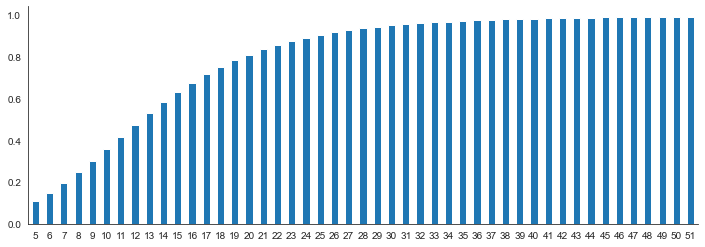

In [46]:
with sns.axes_style("white"):
    sent_length.sort_index().cumsum().div(sent_length.sum()).loc[5:51].plot.bar(figsize=(12, 4), rot=0)
    sns.despine();

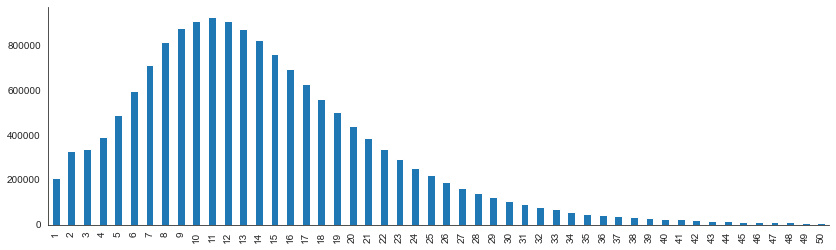

In [47]:
with sns.axes_style("white"):
    sent_length.sort_index().loc[:50].plot.bar(figsize=(14, 4))
    sns.despine();

### Create bi- and trigrams

Combine all filings

In [69]:
files = selected_section_path.glob('*.txt')
texts = [f.read_text() for f in files]
unigrams = ngram_path / 'ngrams_1.txt'
unigrams.write_text('\n'.join(texts))

1827326308

In [70]:
texts = unigrams.read_text()

In [71]:
n_grams = []
start = time()
for i, n in enumerate([2, 3]):
    sentences = LineSentence(ngram_path / f'ngrams_{n-1}.txt')
    phrases = Phrases(sentences=sentences,
                      min_count=25,  # ignore terms with a lower count
                      threshold=0.5,  # accept phrases with higher score
                      max_vocab_size=4000000,  # prune of less common words to limit memory use
                      delimiter=b'_',  # how to join ngram tokens
                      scoring='npmi')

    s = pd.DataFrame([[k.decode('utf-8'), v] for k, v in phrases.export_phrases(sentences)], 
                     columns=['phrase', 'score']).assign(length=n)

    n_grams.append(s.groupby('phrase').score.agg(['mean', 'size']))
    print(n_grams[-1].nlargest(5, columns='size'))
    
    grams = Phraser(phrases)
    sentences = grams[sentences]
    (ngram_path / f'ngrams_{n}.txt').write_text('\n'.join([' '.join(s) for s in sentences]))
    
    src_dir = results_path / f'ngrams_{n-1}'
    target_dir = results_path / f'ngrams_{n}'
    if not target_dir.exists():
        target_dir.mkdir()
    
    for f in src_dir.glob('*.txt'):
        text = LineSentence(f)
        text = grams[text]
        (target_dir / f'{f.stem}.txt').write_text('\n'.join([' '.join(s) for s in text]))
    print('\n\tDuration: ', format_time(time() - start))

n_grams = pd.concat(n_grams).sort_values('size', ascending=False)          
n_grams.to_parquet(results_path / 'ngrams.parquet')

                         mean    size
phrase                               
year ended           0.824560  456420
results operations   0.727928  390446
table contents       0.946177  341318
company s            0.588563  312218
financial condition  0.768172  310234

	Duration:  00:30:36
                                            mean    size
phrase                                                  
year_ended december                     0.803816  397878
financial_condition results_operations  0.781534  145569
material_adverse effect                 0.876534  130986
net income                              0.506277  130149
interest income                         0.558110  101746

	Duration:  00:59:33


In [72]:
n_grams.groupby(n_grams.index.str.replace('_', ' ').str.count(' ')).size()

phrase
1    28613
2     9966
3     2336
dtype: int64

### Convert filings to integer sequences based on token count

In [48]:
sentences = (ngram_path / 'ngrams_3.txt').read_text().split('\n')

In [49]:
n = len(sentences)

In [50]:
token_cnt = Counter()
for i, sentence in enumerate(sentences, 1):
    if i % 500000 == 0:
        print(f'{i/n:.1%}', end=' ', flush=True)
    token_cnt.update(sentence.split())
token_cnt = pd.Series(dict(token_cnt.most_common()))
token_cnt = token_cnt.reset_index()
token_cnt.columns = ['token', 'n']  

3.5% 6.9% 10.4% 13.9% 17.4% 20.8% 24.3% 27.8% 31.3% 34.7% 38.2% 41.7% 45.2% 48.6% 52.1% 55.6% 59.1% 62.5% 66.0% 69.5% 73.0% 76.4% 79.9% 83.4% 86.8% 90.3% 93.8% 97.3% 

In [51]:
token_cnt.to_parquet(results_path / 'token_cnt')

In [52]:
token_cnt.n.describe(deciles).apply(lambda x: f'{x:,.0f}')

count      205,447
mean           919
std         13,443
min              1
10%              1
20%              2
30%              4
40%              6
50%             12
60%             25
70%             40
80%             82
90%            269
max      1,926,643
Name: n, dtype: object

In [53]:
token_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205447 entries, 0 to 205446
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   token   205447 non-null  object
 1   n       205447 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


In [54]:
token_cnt.nlargest(10, columns='n')

,token,n
0,million,1926643
1,business,1210252
2,company,1061550
3,products,1035118
4,sales,864927
5,net,853937
6,including,794889
7,market,794453
8,costs,772244
9,increase,756554


In [55]:
token_cnt.sort_values(by=['n', 'token'], ascending=[False, True]).head()

,token,n
0,million,1926643
1,business,1210252
2,company,1061550
3,products,1035118
4,sales,864927


In [56]:
token_by_freq = token_cnt.sort_values(by=['n', 'token'], ascending=[False, True]).token
token2id = {token: i for i, token in enumerate(token_by_freq, 3)}

In [57]:
len(token2id)

205447

In [58]:
for token, i in token2id.items():
    print(token, i)
    break

million 3


In [59]:
def generate_sequences(min_len=100, max_len=20000, num_words=25000, oov_char=2):
    if not vector_path.exists():
        vector_path.mkdir()
    seq_length = {}
    skipped = 0
    for i, f in enumerate((results_path / 'ngrams_3').glob('*.txt'), 1):
        file_id = f.stem
        text = f.read_text().split('\n')
        vector = [token2id[token] if token2id[token] + 2 < num_words else oov_char 
                  for line in text 
                  for token in line.split()]
        vector = vector[:max_len]
        if len(vector) < min_len:
            skipped += 1
            continue
        seq_length[int(file_id)] = len(vector)
        np.save(vector_path / f'{file_id}.npy', np.array(vector))
    seq_length = pd.Series(seq_length)
    return seq_length

In [60]:
seq_length = generate_sequences()

In [61]:
pd.Series(seq_length).to_csv(results_path / 'seq_length.csv')

In [62]:
seq_length.describe(deciles)

count    16535.000000
mean     10946.534079
std       5217.391683
min        121.000000
10%       4088.200000
20%       6159.000000
30%       7804.000000
40%       9229.600000
50%      10687.000000
60%      12124.600000
70%      13782.400000
80%      15908.600000
90%      19190.000000
max      20000.000000
dtype: float64

In [63]:
seq_length.sum()

181000941

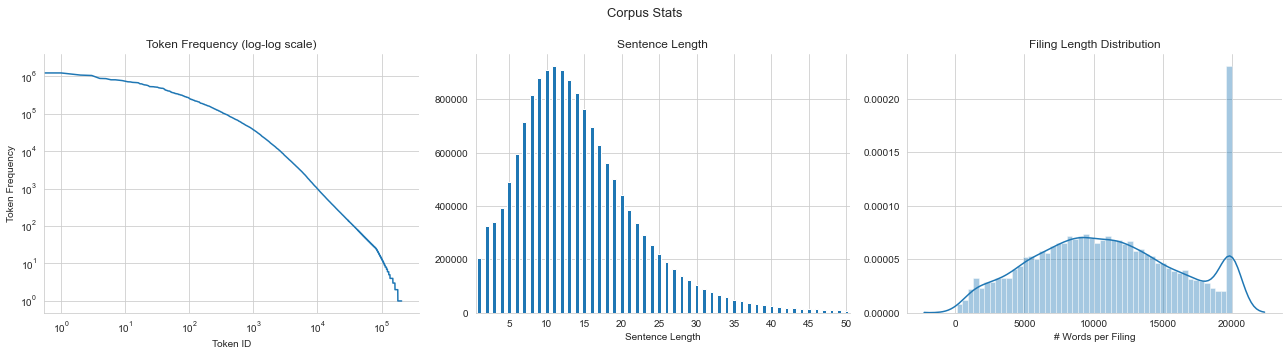

In [64]:
fig, axes = plt.subplots(ncols=3, figsize=(18,5))
token_cnt.n.plot(logy=True, logx=True, ax=axes[0], title='Token Frequency (log-log scale)')
sent_length.sort_index().loc[:50].plot.bar(ax=axes[1], rot=0, title='Sentence Length')

n=5
ticks = axes[1].xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in axes[1].xaxis.get_ticklabels()]
axes[1].xaxis.set_ticks(ticks[n-1::n])
axes[1].xaxis.set_ticklabels(ticklabels[n-1::n])
axes[1].set_xlabel('Sentence Length')

sns.distplot(seq_length, ax=axes[2], bins=50)
axes[0].set_ylabel('Token Frequency')
axes[0].set_xlabel('Token ID')

axes[2].set_xlabel('# Words per Filing')
axes[2].set_title('Filing Length Distribution')

fig.suptitle('Corpus Stats', fontsize=13)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'sec_seq_len', dpi=300);

In [65]:
files = vector_path.glob('*.npy')
filings = sorted([int(f.stem) for f in files])

## Prepare Model Data

### Create weekly forward returns

In [67]:
prices = pd.read_hdf(results_path / 'sec_returns.h5', 'prices')
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1405358 entries, 2013-09-17 to 2015-01-23
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   filing  1405358 non-null  int64  
 1   ticker  1405358 non-null  object 
 2   open    1405304 non-null  float64
 3   high    1405322 non-null  float64
 4   low     1405322 non-null  float64
 5   close   1405323 non-null  float64
 6   volume  1405323 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 85.8+ MB


In [68]:
fwd_return = {}
for filing in filings:
    date_filed = filing_index.at[filing, 'date_filed']
    price_data = prices[prices.filing==filing].close.sort_index()
    
    try:
        r = (price_data
             .pct_change(periods=5)
             .shift(-5)
             .loc[:date_filed]
             .iloc[-1])
    except:
        continue
    if not np.isnan(r) and -.5 < r < 1:
        fwd_return[filing] = r

In [69]:
len(fwd_return)

16352

### Combine returns with filing data

In [70]:
y, X = [], []
for filing_id, fwd_ret in fwd_return.items():
    X.append(np.load(vector_path / f'{filing_id}.npy') + 2)
    y.append(fwd_ret)
y = np.array(y)

In [71]:
len(y), len(X)

(16352, 16352)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1)

### Pad sequences

In the second step, we convert the lists of integers into fixed-size arrays that we can stack and provide as input to our RNN. The pad_sequence function produces arrays of equal length, truncated, and padded to conform to maxlen, as follows:

In [73]:
maxlen = 20000

In [74]:
X_train = pad_sequences(X_train, 
                        truncating='pre', 
                        padding='pre', 
                        maxlen=maxlen)

X_test = pad_sequences(X_test, 
                       truncating='pre', 
                       padding='pre', 
                       maxlen=maxlen)

In [75]:
X_train.shape, X_test.shape

((14716, 20000), (1636, 20000))

## Define Model Architecture

In [76]:
K.clear_session()

Now we can define our RNN architecture. The first layer learns the word embeddings. We define the embedding dimension as previously using the input_dim keyword to set the number of tokens that we need to embed, the output_dim keyword, which defines the size of each embedding, and how long each input sequence is going to be.

In [77]:
embedding_size = 100

Note that we are using GRUs this time, which train faster and perform better on smaller data. We are also using dropout for regularization, as follows:

In [78]:
input_dim = X_train.max() + 1

In [79]:
rnn = Sequential([
    Embedding(input_dim=input_dim, 
              output_dim=embedding_size, 
              input_length=maxlen,
             name='EMB'),
    BatchNormalization(name='BN1'),
    Bidirectional(GRU(32), name='BD1'),
    BatchNormalization(name='BN2'),
    Dropout(.1, name='DO1'),
    Dense(5, name='D'),
    Dense(1, activation='linear', name='OUT')
])

The resulting model has over 2 million parameters.

In [80]:
rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EMB (Embedding)              (None, 20000, 100)        2500000   
_________________________________________________________________
BN1 (BatchNormalization)     (None, 20000, 100)        400       
_________________________________________________________________
BD1 (Bidirectional)          (None, 64)                25728     
_________________________________________________________________
BN2 (BatchNormalization)     (None, 64)                256       
_________________________________________________________________
DO1 (Dropout)                (None, 64)                0         
_________________________________________________________________
D (Dense)                    (None, 5)                 325       
_________________________________________________________________
OUT (Dense)                  (None, 1)                 6

In [81]:
rnn.compile(loss='mse', 
            optimizer='Adam',
            metrics=[RootMeanSquaredError(name='RMSE'),
                     MeanAbsoluteError(name='MAE')])

## Train model

In [82]:
early_stopping = EarlyStopping(monitor='val_MAE', 
                               patience=5,
                               restore_best_weights=True)

Training stops after eight epochs and we recover the weights for the best models to find a high test AUC of 0.9346:

In [83]:
training = rnn.fit(X_train,
                   y_train,
                   batch_size=32,
                   epochs=100,
                   validation_data=(X_test, y_test),
                   callbacks=[early_stopping],
                   verbose=1)

Epoch 1/100
460/460 [==============================] - 458s 995ms/step - loss: 0.1034 - RMSE: 0.3215 - MAE: 0.1967 - val_loss: 0.0078 - val_RMSE: 0.0880 - val_MAE: 0.0541
Epoch 2/100
460/460 [==============================] - 446s 968ms/step - loss: 0.0202 - RMSE: 0.1423 - MAE: 0.0809 - val_loss: 0.0085 - val_RMSE: 0.0920 - val_MAE: 0.0582
Epoch 3/100
460/460 [==============================] - 432s 939ms/step - loss: 0.0109 - RMSE: 0.1044 - MAE: 0.0624 - val_loss: 0.0072 - val_RMSE: 0.0847 - val_MAE: 0.0530
Epoch 4/100
460/460 [==============================] - 427s 929ms/step - loss: 0.0088 - RMSE: 0.0940 - MAE: 0.0560 - val_loss: 0.0069 - val_RMSE: 0.0831 - val_MAE: 0.0505
Epoch 5/100
460/460 [==============================] - 424s 922ms/step - loss: 0.0083 - RMSE: 0.0912 - MAE: 0.0543 - val_loss: 0.0070 - val_RMSE: 0.0834 - val_MAE: 0.0519
Epoch 6/100
460/460 [==============================] - 426s 925ms/step - loss: 0.0082 - RMSE: 0.0907 - MAE: 0.0543 - val_loss: 0.0068 - val_RMSE:

## Evaluate the Results

In [84]:
df = pd.DataFrame(training.history)
df.to_csv(results_path / 'rnn_sec.csv', index=False)

In [85]:
df.index += 1

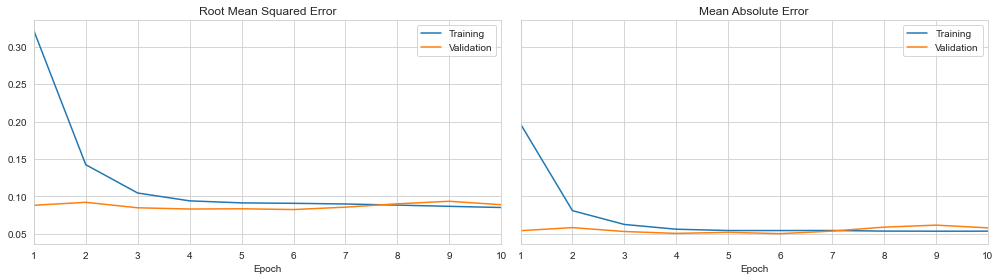

In [86]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
df[['RMSE', 'val_RMSE']].rename(columns={'RMSE': 'Training', 
                                         'val_RMSE': 'Validation'}).plot(ax=axes[0], title='Root Mean Squared Error')
df[['MAE', 'val_MAE']].rename(columns={'MAE': 'Training', 
                                         'val_MAE': 'Validation'}).plot(ax=axes[1], title='Mean Absolute Error')
for i in [0, 1]:
    axes[i].set_xlim(1, 10)
    axes[i].set_xlabel('Epoch')
fig.tight_layout()
fig.savefig(results_path / 'sec_cv_performance', dpi=300);

In [87]:
y_score = rnn.predict(X_test)

In [88]:
rho, p = spearmanr(y_score.squeeze(), y_test)

In [89]:
print(f'{rho*100:.2f} ({p:.2%})')

4.11 (9.68%)


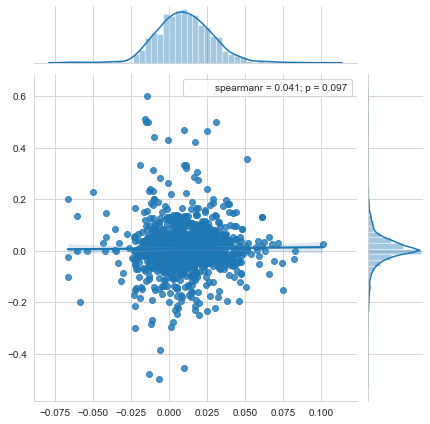

In [90]:
g = sns.jointplot(y_score.squeeze(), y_test, kind='reg')
g.annotate(spearmanr);